In [1]:
import numpy as np
import pandas as pd
import os
import spacy
import en_core_web_sm
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
!pip install vaderSentiment
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# preprocessing the data file
#  read the data
df1 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/drugsComTrain_raw.csv")
df2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/drugsComTest_raw.csv")
# combine two file
df = pd.concat([df1, df2])
df
# rename the cols
df.columns = ['ID','drug name','condition','review','rating','date','useful count']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


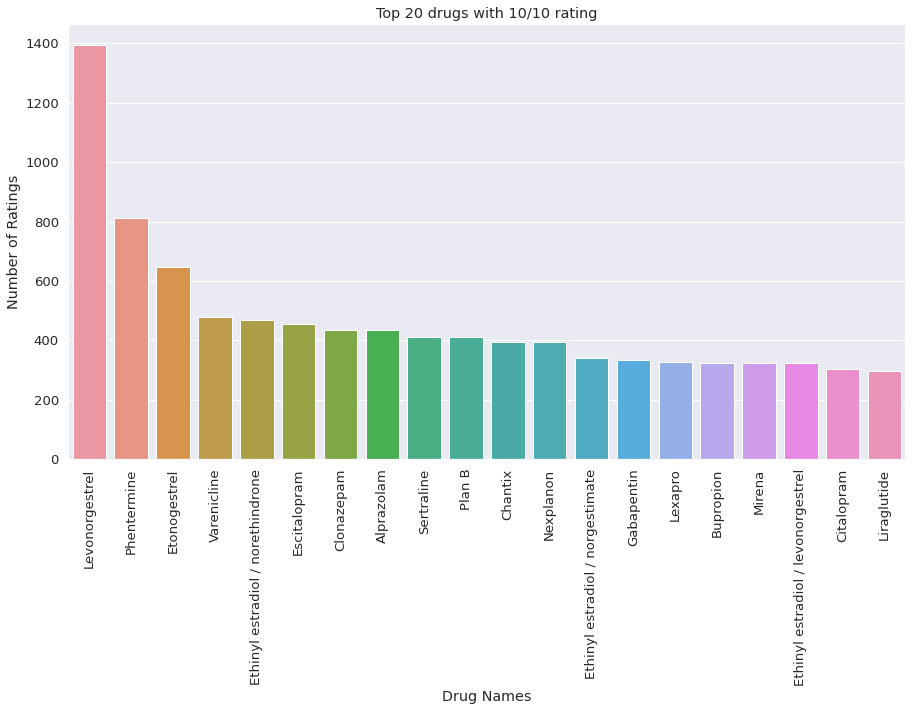

In [51]:
import seaborn as sns
#!pip install matplotlib
import matplotlib.pyplot as plt

# Setting the Parameter
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df.loc[df.rating == 10, "drug name"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

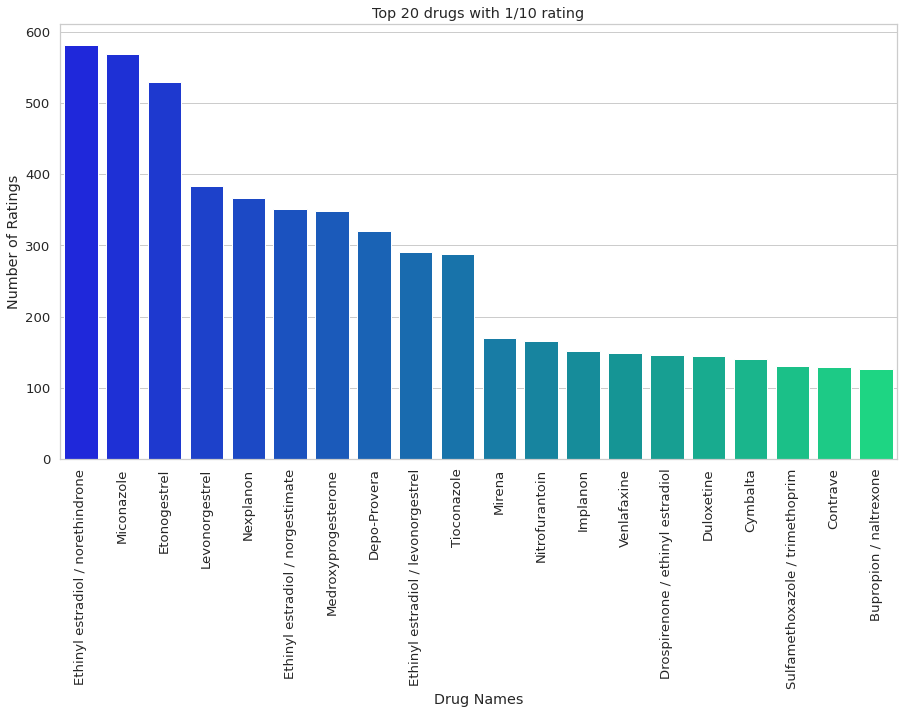

In [52]:
# Setting the Parameter
sns.set(font_scale = 1.2, style = 'whitegrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df.loc[df.rating == 1, "drug name"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

Text(0.5, 0, 'Rating')

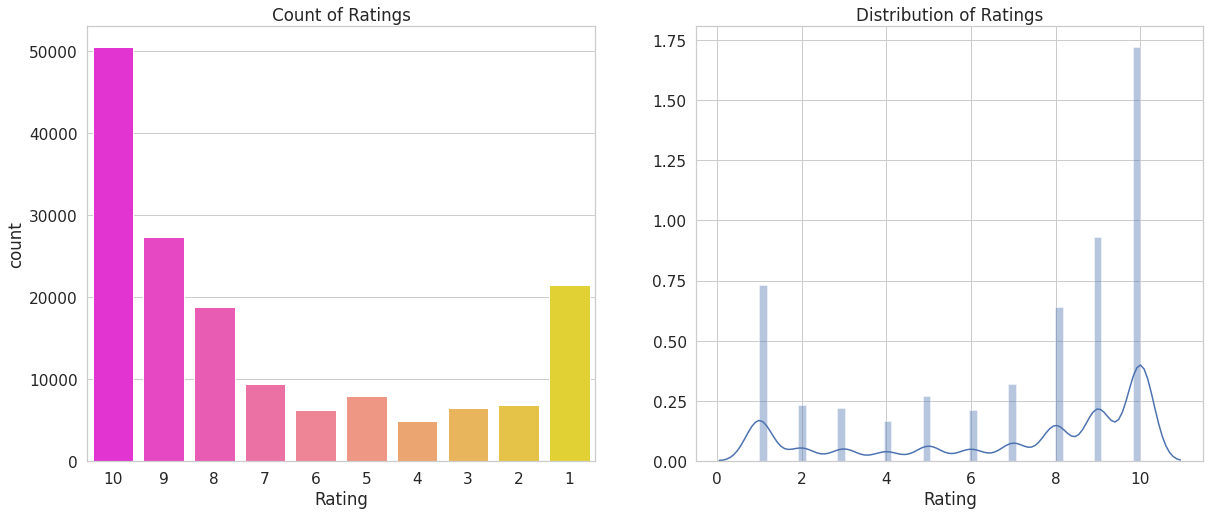

In [53]:
# A countplot of the ratings so we can see the distribution of the ratings
plt.rcParams['figure.figsize'] = [20,8]
sns.set(font_scale = 1.4, style = 'whitegrid')
fig, ax = plt.subplots(1, 2)

sns_1 = sns.countplot(df['rating'], palette = 'spring', order = list(range(10, 0, -1)), ax = ax[0])
sns_2 = sns.distplot(df['rating'], ax = ax[1])
sns_1.set_title('Count of Ratings')
sns_1.set_xlabel("Rating")

sns_2.set_title('Distribution of Ratings')
sns_2.set_xlabel("Rating")

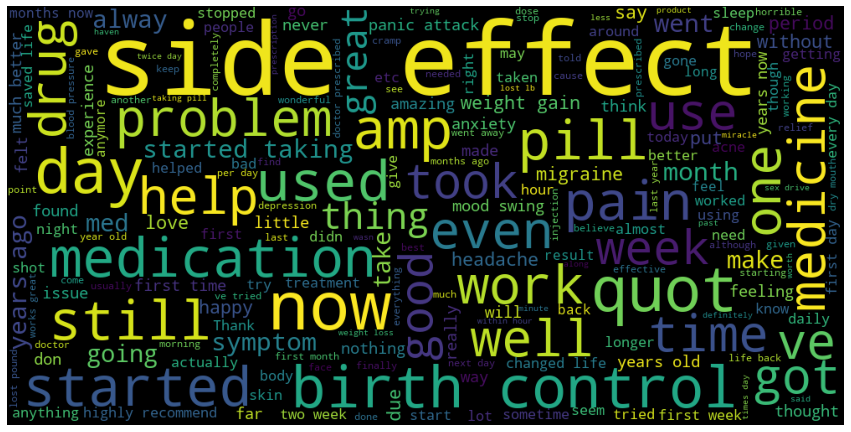

In [54]:
#!pip install wordcloud
from wordcloud import WordCloud# Word cloud of the reviews with rating equal to 10
df_rate_ten = df.loc[df.rating == 10, 'review']
k = (' '.join(df_rate_ten))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

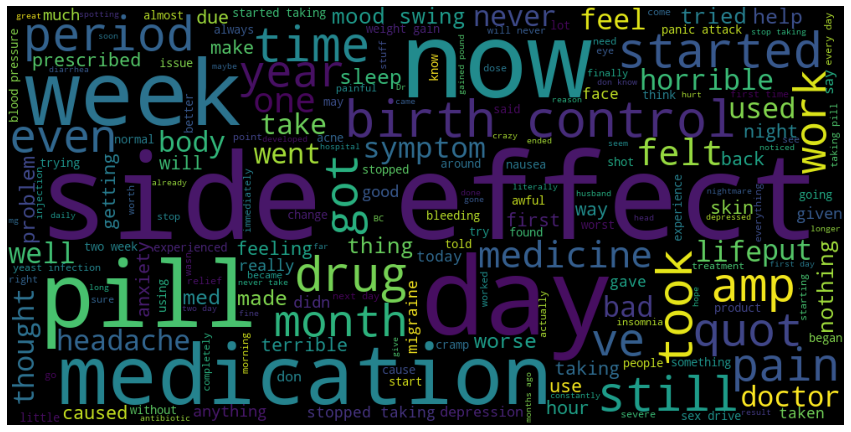

In [55]:
from wordcloud import WordCloud# Word cloud of the reviews with rating equal to 1
df_rate_ten = df.loc[df.rating == 1, 'review']
k = (' '.join(df_rate_ten))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

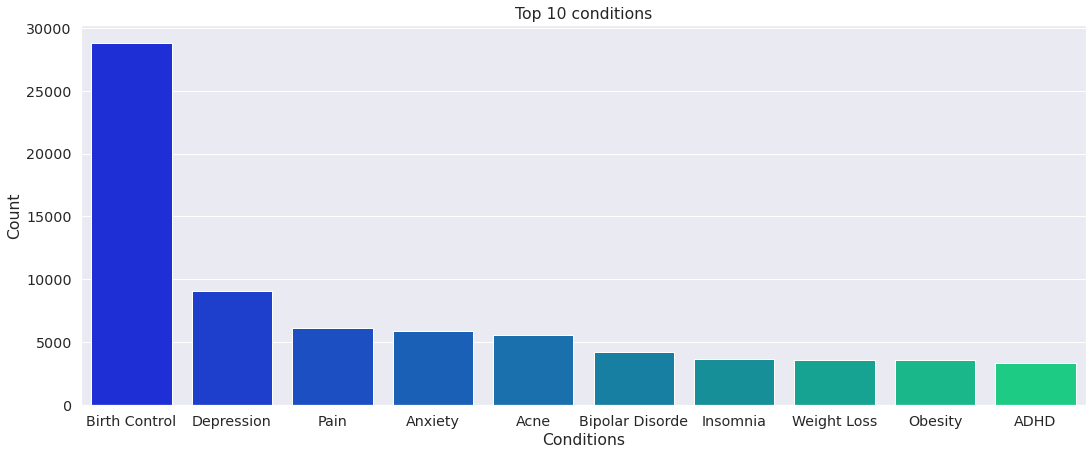

In [56]:
# This barplot show the top 10 conditions the people are suffering.
cond = dict(df['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [18, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

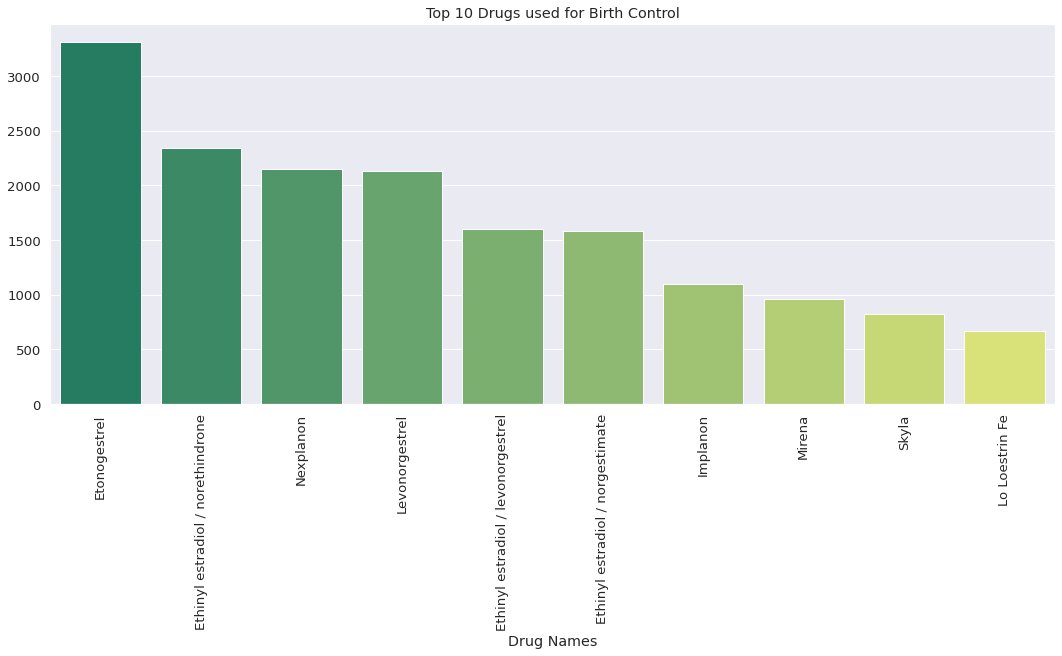

In [57]:
# Top 10 drugs which are used for the top condition, that is Birth Control
df = df[df['condition'] == 'Birth Control']['drug name'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = df.index, y = df.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs used for Birth Control")
plt.setp(sns_.get_xticklabels(), rotation = 90);

In [0]:
df2 = df[df['useful count'] > 10]  

In [5]:
df_condition = df2.groupby(['condition'])['drug name'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drug name
706,Rejection Prophylaxis,1
707,Ectopic Pregnancy,1
708,"Skin Disinfection, Preoperative",1
709,Muscle Twitching,1
710,Post-Cholecystectomy Diarrhea,1
711,Lewy Body Dementia,1
712,Short Stature for Age,1
713,Meningitis,1
714,ailure to Thrive,1
715,Short Stature,1


In [0]:
df_condition_1 = df_condition[df_condition['drug name'] == 1].reset_index()

all_list = set(df.index)

# deleting them
condition_list = []
for i,j in enumerate(df['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
df = df.iloc[list(new_idx)].reset_index()
del df['index']

In [7]:
df.shape

(160684, 7)

In [0]:
# removing the conditions with <span> in it.

all_list = set(df.index)
span_list = []
for i,j in enumerate(df['condition']):
    if "</span>" in str(j):
        span_list.append(i)
new_idx = all_list.difference(set(span_list))
df = df.iloc[list(new_idx)].reset_index()
del df['index']

In [9]:
import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# removing some stopwords from the list of stopwords as they are important for drug recommendation

stops = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
            "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [0]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

# create a list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()
punctuations = string.punctuation
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens


In [12]:
%time df['review_clean'] = df['review'].apply(review_to_words)
df.head()

CPU times: user 1min 36s, sys: 318 ms, total: 1min 36s
Wall time: 1min 36s


,ID,drug name,condition,review,rating,date,useful count,review_clean
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,no side effect take combin bystol mg fish oil
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,son halfway fourth week intuniv becam concern ...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,use take anoth oral contracept pill cycl happi...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,first time use form birth control glad went pa...
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,suboxon complet turn life around feel healthie...


In [0]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))
#  tf-idf vector
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [0]:
# part 1---vader sentiment analyzer for c_review
analyzer = SentimentIntensityAnalyzer()
# create new col vaderReviewScore based on C-review
df['vaderReviewScore'] = df['review_clean'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# define the positive, neutral and negative
positive_num = len(df[df['vaderReviewScore'] >=0.05])
neutral_num = len(df[(df['vaderReviewScore'] >-0.05) & (df['vaderReviewScore']<0.05)])
negative_num = len(df[df['vaderReviewScore']<=-0.05])

# create new col vaderSentiment based on vaderReviewScore
df['vaderSentiment'] = df['vaderReviewScore'].map(lambda x:int(2) if x>=0.05 else int(1) if x<=-0.05 else int(0) )
df['vaderSentiment'].value_counts() # 2-pos: 99519; 1-neg: 104434; 0-neu: 11110

# label pos/neg/neu based on vaderSentiment result
df.loc[df['vaderReviewScore'] >=0.05,"vaderSentimentLabel"] ="positive"
df.loc[(df['vaderReviewScore'] >-0.05) & (df['vaderReviewScore']<0.05),"vaderSentimentLabel"]= "neutral"
df.loc[df['vaderReviewScore']<=-0.05,"vaderSentimentLabel"] = "negative"

In [15]:
df['vaderReviewScore'].max()

0.992

In [16]:
df['vaderReviewScore'].min()

-0.9976

In [0]:
#Normalizing "vaderReviewScore"
criteria = [df['vaderReviewScore'].between(-0.997, -0.799), df['vaderReviewScore'].between(-0.798, -0.601), df['vaderReviewScore'].between(-0.600, 0.403), df['vaderReviewScore'].between(-0.402, -0.205), df['vaderReviewScore'].between(-0.204, -0.007), df['vaderReviewScore'].between(-0.006,0.191), df['vaderReviewScore'].between(0.192, 0.389), df['vaderReviewScore'].between(0.390, 0.587), df['vaderReviewScore'].between(0.588, 0.785), df['vaderReviewScore'].between(0.786, 1)]
values = [1, 2, 3,4,5,6,7,8,9,10]

df['normalVaderScore'] = np.select(criteria, values, 0)

In [19]:
df

,ID,drug name,condition,review,rating,date,useful count,review_clean,vaderReviewScore,vaderSentiment,vaderSentimentLabel,normalVaderScore
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,no side effect take combin bystol mg fish oil,-0.2960,1,negative,3
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,son halfway fourth week intuniv becam concern ...,0.6929,2,positive,9
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,use take anoth oral contracept pill cycl happi...,0.2732,2,positive,3
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,first time use form birth control glad went pa...,0.4199,2,positive,8
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,suboxon complet turn life around feel healthie...,0.8934,2,positive,10
...,...,...,...,...,...,...,...,...,...,...,...,...
159803,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125,wrote first report mid octob not alcohol sinc ...,0.9362,2,positive,10
159804,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34,given iv surgey immedi becam anxious could not...,-0.2732,1,negative,3
159805,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35,limit improv month develop bad rash md refus c...,-0.7351,1,negative,2
159806,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79,thyroid medic year spent first synthroid vario...,0.7655,2,positive,9


In [20]:
#Final Normalized Score combining Rating and normalVaderScore
df['meanNormalizedScore'] = (df['rating'] + df['normalVaderScore'])/2
df.head()

,ID,drug name,condition,review,rating,date,useful count,review_clean,vaderReviewScore,vaderSentiment,vaderSentimentLabel,normalVaderScore,meanNormalizedScore
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,no side effect take combin bystol mg fish oil,-0.2960,1,negative,3,6.0
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,son halfway fourth week intuniv becam concern ...,0.6929,2,positive,9,8.5
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,use take anoth oral contracept pill cycl happi...,0.2732,2,positive,3,4.0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,first time use form birth control glad went pa...,0.4199,2,positive,8,8.0
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,suboxon complet turn life around feel healthie...,0.8934,2,positive,10,9.5


In [31]:
#Sorting Data based on Condition and then by drug
grouped = df.groupby(['condition','drug name']).agg({'meanNormalizedScore' : ['mean']})
grouped.to_csv('Grouped_Drug_Recommendation_Normalized')
grouped.head(10)

meanNormalizedScore
                                                         mean
condition drug name                                          
ADHD      Adderall                                   6.984375
          Adderall XR                                7.149533
          Adzenys XR-ODT                             6.805556
          Amantadine                                 5.666667
          Amphetamine                                6.522727
          Amphetamine / dextroamphetamine            6.929178
          Aptensio XR                                5.833333
          Armodafinil                                6.937500
          Atomoxetine                                5.103448
          Bupropion                                  6.879310

In [0]:
#Verification using Machine Learning Models
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(df, test_size = 0.25, random_state = 0)

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

cv = CountVectorizer(max_features = 20000, ngram_range = (4, 4))
pipeline = Pipeline([('vect',cv)])

x_train_features = pipeline.fit_transform(x_train['review_clean'])
x_test_features = pipeline.fit_transform(x_test['review_clean'])

print("x_train_features :", x_train_features.shape)
print("x_test_features :", x_test_features.shape)
# let's make a new column review sentiment 

df.loc[(df['rating'] >= 5), 'Review_Sentiment'] = 1
df.loc[(df['rating'] < 5), 'Review_Sentiment'] = 0

df['Review_Sentiment'].value_counts()

x_train_features : (119856, 20000)
x_test_features : (39952, 20000)


1.0    120085
0.0     39723
Name: Review_Sentiment, dtype: int64

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_score, confusion_matrix, recall_score
from sklearn.metrics import classification_report
# making our dependent variable



features = df['review_clean'] # the features we want to analyze
labels = df['Review_Sentiment'] # the labels, we want to test against
X_train, X_test, y_train, y_test= train_test_split(features, labels, test_size=0.2, random_state=0)

clf2 = LogisticRegression(random_state=0,solver='lbfgs',max_iter=2000,multi_class='auto')
#clf3 = SVC(kernel="linear", C=5)
clf7 = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=10, tol=None)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [37]:
# Logistic Regression

x_train1 = x_train['review_clean']
pipe2 = Pipeline([('vectorizer', bow_vector),
                ('classifier', clf2)])
pipe2.fit(X_train, y_train)
y_pred2 = pipe2.predict(X_test)

logreg_accuracy = accuracy_score(y_test, y_pred2)
print("Log Reg: ", logreg_accuracy )

Log Reg:  0.9133032976659784


In [0]:
#AUC
from sklearn.metrics import roc_curve, auc
y_score = pipe2.fit(X_train, y_train).decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

In [35]:
#Classification Report
target_names = ["class 1", "class 2"]
print(classification_report(y_test, y_pred2,target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.86      0.78      0.82      7920
     class 2       0.93      0.96      0.94     24042

    accuracy                           0.91     31962
   macro avg       0.89      0.87      0.88     31962
weighted avg       0.91      0.91      0.91     31962



In [31]:
#Confusion Matrix
cm2 = confusion_matrix(y_pred=y_pred2, y_true=y_test)
cm2

array([[ 6199,  1721],
       [ 1050, 22992]])

In [32]:
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.9438023599693802


In [39]:
#SGD
pipe7 = Pipeline([('vectorizer', bow_vector),
               ('classifier', clf7)])
pipe7.fit(X_train, y_train)
y_pred7 = pipe7.predict(X_test)
sgd_accuracy = accuracy_score(y_test, y_pred7)
print("SGD: ", sgd_accuracy)

SGD:  0.8504161191414805


In [40]:
#AUC
from sklearn.metrics import roc_curve, auc
y_score2 = pipe7.fit(X_train, y_train).decision_function(X_test)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_score2)
print('AUC: {}'.format(auc(fpr2, tpr2)))

AUC: 0.903384454939546


In [41]:
#Classification Report
target_names = ["class 1", "class 2"]
print(classification_report(y_test, y_pred7,target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.81      0.52      0.63      7920
     class 2       0.86      0.96      0.91     24042

    accuracy                           0.85     31962
   macro avg       0.83      0.74      0.77     31962
weighted avg       0.85      0.85      0.84     31962



In [42]:
#Confusion Matrix
cm2 = confusion_matrix(y_pred=y_pred7, y_true=y_test)
cm2

array([[ 4109,  3811],
       [  970, 23072]])

In [0]:
clf5 = MultinomialNB()

In [45]:
pipe5 = Pipeline([
                 ('vectorizer', bow_vector),
                 ('classifier', clf5)])
pipe5.fit(X_train, y_train)
y_pred5 = pipe5.predict(X_test)
print("MultinomialNB: ", accuracy_score(y_test, y_pred5))

MultinomialNB:  0.877886239909893


In [48]:
#AUC
from sklearn.metrics import roc_curve, auc
y_score3 = pipe5.fit(X_train, y_train).predict_proba(X_test)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_score3[:,1])
print('AUC: {}'.format(auc(fpr3, tpr3)))

AUC: 0.9084264731585047


In [49]:
#Classification Report
target_names = ["class 1", "class 2"]
print(classification_report(y_test, y_pred5,target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.87      0.60      0.71      7920
     class 2       0.88      0.97      0.92     24042

    accuracy                           0.88     31962
   macro avg       0.87      0.78      0.82     31962
weighted avg       0.88      0.88      0.87     31962



In [50]:
#Confusion Matrix
cm3 = confusion_matrix(y_pred=y_pred5, y_true=y_test)
cm3

array([[ 4755,  3165],
       [  738, 23304]])